In [87]:
import pandas as pd
from database.adatabase import ADatabase
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from tqdm import tqdm
from processor.processor import Processor as p
from asset.exposure import Exposure

In [88]:
sec = ADatabase("sec")
market = ADatabase("market")

In [89]:
market.connect()
index = market.retrieve("sp500")
market.disconnect()
factors = ["assets","liabilities","reference_price"]


In [90]:
market.connect()
sec.connect()
factors_df = []
for row in tqdm(index.iterrows()):
    try:
        ticker = row[1]["ticker"]
        cik = int(row[1]["CIK"])
        price = p.column_date_processing(market.query("prices",{"ticker":ticker}))
        price.sort_values("date")
        price["year"] = [x.year for x in price["date"]]
        price["quarter"] = [x.quarter for x in price["date"]]
        filings = p.column_date_processing(sec.query("filings",{"cik":cik}))
        filings["year"] = [x.year if x.quarter < 4 else x.year + 1 for x in filings["date"]]
        filings["quarter"] = [x.quarter + 1 if x.quarter < 4 else 1 for x in filings["date"]]
        ticker_factors = filings.drop(["date","cik"],axis=1).groupby(["year","quarter"]).mean().reset_index()
        price = price.drop(["date","ticker"],axis=1).groupby(["year","quarter"]).mean().reset_index()
        ticker_factors = ticker_factors.merge(price,on=["year","quarter"],how="left")
        ticker_factors["ticker"] = ticker
        ticker_factors["reference_price"] = ticker_factors["adjclose"].shift(1)
        ticker_factors["y"] = ticker_factors["adjclose"].shift(-1)
        factors_df.append(ticker_factors[["year","quarter","ticker","adjclose","y"]+factors])
    except Exception as e:
        print(ticker,str(e))
        continue
sec.disconnect()
market.disconnect()
factors_df = pd.concat(factors_df).sort_values(["year","quarter"])

26it [00:01, 19.22it/s]

AMTM 'date'


63it [00:03, 18.38it/s]

BRK.B 'date'


67it [00:04, 17.06it/s]

BLK 'date'


75it [00:04, 16.14it/s]

BF.B 'date'


502it [00:31, 15.85it/s]

ZTS 'date'


In [91]:
factors_df.sort_values(["ticker","year","quarter"])

,year,quarter,ticker,adjclose,y,assets,liabilities,reference_price
0,2013,2,A,28.453485,30.957480,1.059450e+10,5.326500e+09,NaN
1,2013,3,A,30.957480,34.982295,1.056150e+10,5.315000e+09,28.453485
2,2013,4,A,34.982295,37.984034,1.040700e+10,5.419500e+09,30.957480
3,2014,1,A,37.984034,37.120989,1.061100e+10,5.374000e+09,34.982295
4,2014,2,A,37.120989,37.846924,1.066200e+10,5.294000e+09,37.984034
...,...,...,...,...,...,...,...,...
42,2023,4,ZBRA,228.265714,267.628852,7.492500e+09,4.630000e+09,271.507302
43,2024,1,ZBRA,267.628852,304.088016,7.430000e+09,4.557000e+09,228.265714
44,2024,2,ZBRA,304.088016,335.879531,7.417500e+09,4.533000e+09,267.628852
45,2024,3,ZBRA,335.879531,387.112069,7.282500e+09,4.180000e+09,304.088016


In [92]:
model = XGBRegressor()
training_data = factors_df[(factors_df["year"]>=2013) & (factors_df["year"]<2020)].dropna()
sim = factors_df[(factors_df["year"]>=2019)].dropna(subset=factors)
model.fit(training_data[factors],training_data["y"])
sim["prediction"] = model.predict(sim[factors])
sim = sim[["year","quarter","ticker","prediction"]]

In [93]:
market.connect()
prices = []
for ticker in tqdm(index["ticker"]):
    try:
        price = p.column_date_processing(market.query("prices",{"ticker":ticker}))
        price.sort_values("date",inplace=True)
        price["year"] = [x.year for x in price["date"]]
        price["quarter"] = [x.quarter for x in price["date"]]
        price.sort_values("date",inplace=True)
        price = price.merge(sim[["year","quarter","ticker","prediction"]],on=["year","quarter","ticker"],how="left")
        prices.append(price)
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

 12%|███████████████████████▎                                                                                                                                                                     | 62/502 [00:03<00:21, 20.89it/s]

'date'


 16%|█████████████████████████████▎                                                                                                                                                               | 78/502 [00:04<00:20, 20.20it/s]

'date'


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 502/502 [00:27<00:00, 18.22it/s]

'date'


In [94]:
simulation = pd.concat(prices).dropna()

In [95]:
tickers = list(simulation[simulation["year"]==2020]["ticker"].unique())
simulation = simulation[simulation["ticker"].isin(tickers)]

In [96]:
simulation["factor"] = simulation["prediction"]/simulation["adjclose"] - 1

In [97]:
simulation["rank"] = simulation.groupby(["date"])["factor"].rank(method="dense",ascending=False).astype(int)

In [116]:
simulation["exposure"] = [1 if x <= simulation["rank"].max() * 0.10 else -1 if x > simulation["rank"].max() * 0.90 else 1.0/6.0 for x in simulation["rank"]]

In [117]:
simulation["sell_price"] = simulation["adjclose"]
simulation.sort_values("date",inplace=True)
trades = simulation[(simulation["year"]>=2020)][["year","quarter","ticker","exposure","adjclose","sell_price"]].groupby(["year","quarter","ticker"]).agg({"exposure":"first","adjclose":"first","sell_price":"last"}).reset_index()
trades["return"] = (trades["sell_price"] - trades["adjclose"])/trades["adjclose"]
trades["return"] = trades["return"] * trades["exposure"]
analysis = trades[["year","quarter","exposure","return"]].groupby(["year","quarter","exposure"]).mean().pivot_table(index=["year","quarter"],columns="exposure",values="return").reset_index()

In [118]:
trades.sort_values("return",ascending=False).head(40)

,year,quarter,ticker,exposure,adjclose,sell_price,return
403,2020,2,CZR,1.0,11.690000,40.060000,2.426861
457,2020,2,HAL,1.0,6.151865,12.141571,0.973641
574,2020,2,RCL,1.0,25.710911,50.184666,0.951882
4185,2023,1,TSLA,1.0,108.100000,207.460000,0.919149
525,2020,2,MPC,1.0,17.865092,32.535884,0.821199
362,2020,2,BLDR,1.0,11.480000,20.700000,0.803136
549,2020,2,ON,1.0,11.000000,19.820000,0.801818
1825,2021,2,MRNA,1.0,132.550000,234.980000,0.772765
248,2020,1,RCL,-1.0,132.766947,32.096237,0.758251
534,2020,2,NCLH,1.0,9.550000,16.430000,0.720419


In [119]:
trades.iloc[-505:].to_csv("current.csv")

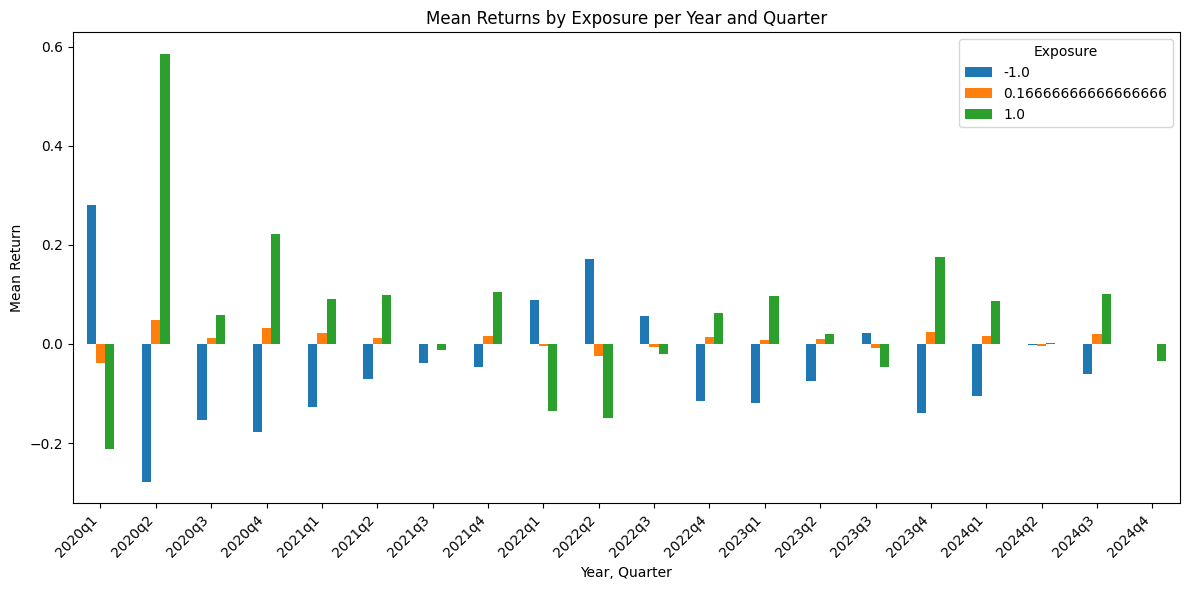

In [120]:
analysis['Year-Quarter'] = analysis["year"].astype(str) + "q" + analysis["quarter"].astype(str)

# Reset index for plotting
analysis.drop(["year","quarter"],axis=1,inplace=True)
analysis.reset_index(drop=True, inplace=True)

# Plot a bar chart
analysis.set_index("Year-Quarter").plot(
    kind="bar",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Customize the plot
plt.xlabel("Year, Quarter")
plt.ylabel("Mean Return")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title="Exposure")
plt.tight_layout()

# Show the plot
plt.show()


In [121]:
portfolio = trades[["year","quarter","return"]].groupby(["year","quarter"]).mean().reset_index()
portfolio["return"] = portfolio["return"] + 1
portfolio["return"] = portfolio["return"].cumprod() - 1

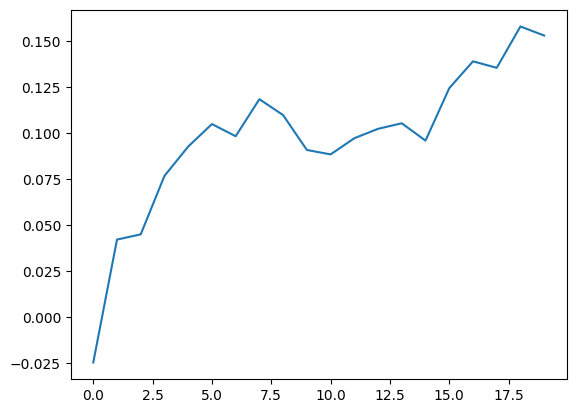

In [122]:
plt.plot(portfolio.index,portfolio["return"])

In [123]:
trades.merge(index,on=["ticker"],how="left")[["year","quarter","GICS Sector","return"]].groupby(["year","quarter","GICS Sector"]).sum().tail(20)

return
year quarter GICS Sector                     
2024 3       Consumer Staples        0.081457
             Energy                 -0.102254
             Financials              1.446199
             Health Care             0.548796
             Industrials             2.066302
             Information Technology  0.467293
             Materials               0.250861
             Real Estate             0.840135
             Utilities               0.257364
     4       Communication Services  0.578282
             Consumer Discretionary  0.222885
             Consumer Staples       -0.158884
             Energy                 -0.117946
             Financials              0.382778
             Health Care            -1.705300
             Industrials             0.104265
             Information Technology -0.345174
             Materials              -0.270292
             Real Estate             0.159095
             Utilities              -0.212338